## Question 2: Partisan Moderation
- Compute **partisan gap** = (total_pro_R − total_pro_D) / (total_pro_R + total_pro_D) per cycle
- Compute separately for direct contributions vs. independent expenditure channels
- Estimate **difference-in-differences** using direct contributions as control group
- Key test: does the IE partisan gap diverge from the direct gap after Citizens United (2010)?

In [18]:
# Load packages + connect to database

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os

conn = sqlite3.connect('../data/citizens_united.db')

os.makedirs('../figures', exist_ok=True)
os.makedirs('../tables',  exist_ok=True)


## 1. Load partisan spending by direction and vehicle type

Query `partisan_spending_monthly` grouped by `Cycle`, `era`, `spending_type`, and `partisan_direction`.
Filter to only `pro_R` and `pro_D` rows (exclude `unaligned`). Amounts already in 2024 dollars.

In [21]:
query = """
    SELECT Cycle, era, spending_type, partisan_direction,
           SUM(total_amount_2024) AS total,
           SUM(n_transactions)    AS n_trans
    FROM partisan_spending_monthly
    WHERE partisan_direction IN ('pro_R', 'pro_D')
    GROUP BY Cycle, era, spending_type, partisan_direction
    ORDER BY Cycle, spending_type, partisan_direction
  """

df = pd.read_sql(query, conn)

df.sample(20, random_state=1)

,Cycle,era,spending_type,partisan_direction,total,n_trans
27,2020,post_CU,individual,pro_R,4.137479e+08,1509291
3,2004,pre_CU,individual,pro_R,3.104511e+08,205235
22,2012,post_CU,pac_independent,pro_D,2.591002e+08,45874
18,2012,post_CU,individual,pro_D,4.294581e+08,610302
23,2012,post_CU,pac_independent,pro_R,6.315819e+08,8485
17,2012,post_CU,527,pro_R,6.505733e+07,10359
21,2012,post_CU,pac_direct,pro_R,2.723181e+06,694
28,2020,post_CU,pac_direct,pro_D,7.148250e+05,373
19,2012,post_CU,individual,pro_R,5.721063e+08,527970
14,2008,pre_CU,pac_independent,pro_D,1.615181e+08,12530


## 2. Compute partisan gap per cycle per spending type

Partisan gap = (pro_R − pro_D) / (pro_R + pro_D).
Ranges from −1 (all Democratic) to +1 (all Republican). 0 = perfect parity.
Compute separately for each vehicle: `individual`, `pac_direct`, `pac_independent`, `527`.

In [23]:
# create pivot table for cycles and types
pivot = df.pivot_table(index='Cycle',
                         columns=['spending_type', 'partisan_direction'],
                         values='total',
                         aggfunc='sum').fillna(0)

print(pivot.columns)
pivot

uppers = ["527", "individual", "pac_direct", "pac_independent"] # first level columns indicies
inners = ["pro_D", "pro_R"] # second level column indicies

# calculate gap between pro-D and pro-R for each spending type
for upper in uppers:
    pro_d = pivot[(upper, 'pro_D')] # get dem spending
    pro_r = pivot[(upper, 'pro_R')] # get rep spending
    raw_gap = pro_r - pro_d # calculate raw gap (positive = more pro-R, negative = more pro-D)
    pivot[(upper, 'gap (R-D)')] = raw_gap # add gap to pivot table
    pct_gap = (raw_gap / (pro_r + pro_d)) * 100 # calculate percentage gap
    pivot[(upper, 'pct_gap (>1 = more Rep)')] = pct_gap # add percentage gap to pivot table

pivot

MultiIndex([(            '527', 'pro_D'),
            (            '527', 'pro_R'),
            (     'individual', 'pro_D'),
            (     'individual', 'pro_R'),
            (     'pac_direct', 'pro_D'),
            (     'pac_direct', 'pro_R'),
            ('pac_independent', 'pro_D'),
            ('pac_independent', 'pro_R')],
           names=['spending_type', 'partisan_direction'])


spending_type                527                  individual                \
partisan_direction         pro_D         pro_R         pro_D         pro_R   
Cycle                                                                        
2004                5.949812e+08  1.776474e+08  3.843370e+08  3.104511e+08   
2008                2.128177e+08  9.865128e+07  6.246281e+08  4.174382e+08   
2012                1.142208e+08  6.505733e+07  4.294581e+08  5.721063e+08   
2020                5.231233e+08  4.558604e+07  5.445846e+08  4.137479e+08   

spending_type         pac_direct               pac_independent                \
partisan_direction         pro_D         pro_R           pro_D         pro_R   
Cycle                                                                          
2004                1.226322e+06  4.356473e+06    3.227336e+08  7.955409e+07   
2008                9.360245e+05  3.765310e+06    1.615181e+08  1.684637e+08   
2012                4.033251e+04  2.723181e+06    2.591002e+08  6.315819e+08   
2020                7.148250e+05  1.113983e+06    9.172969e+08  4.689495e+08   

spending_type                527                            individual  \
partisan_direction     gap (R-D) pct_gap (>1 = more Rep)     gap (R-D)   
Cycle                                                                    
2004               -4.173338e+08              -54.014793 -7.388587e+07   
2008               -1.141664e+08              -36.654183 -2.071900e+08   
2012               -4.916352e+07              -27.423033  1.426483e+08   
2020               -4.775373e+08              -83.968598 -1.308368e+08   

spending_type                                 pac_direct  \
partisan_direction pct_gap (>1 = more Rep)     gap (R-D)   
Cycle                                                      
2004                            -10.634304  3.130151e+06   
2008                            -19.882608  2.829286e+06   
2012                             14.242548  2.682849e+06   
2020                            -13.652545  3.991585e+05   

spending_type                              pac_independent  \
partisan_direction pct_gap (>1 = more Rep)       gap (R-D)   
Cycle                                                        
2004                             56.067815   -2.431795e+08   
2008                             60.180479    6.945684e+06   
2012                             97.081070    3.724817e+08   
2020                             21.826149   -4.483474e+08   

spending_type                               
partisan_direction pct_gap (>1 = more Rep)  
Cycle                                       
2004                            -60.449155  
2008                              2.104869  
2012                             41.819821  
2020                            -32.342543

## 3. Difference-in-Differences (DID) setup

Use **direct contributions** as the control group (unaffected by CU — still subject to contribution limits).
Use **independent expenditures** as the treatment group (unlimited post-CU).

- Pre-CU average = mean of 2004 + 2008 gaps
- Post-CU average = mean of 2012 + 2020 gaps
- DID = (post_IE_gap − pre_IE_gap) − (post_direct_gap − pre_direct_gap)

Positive DID → IE channel became more Republican-favoring after CU relative to direct contributions.
Note: 4 cycles means this is descriptive, not inferential.

In [24]:
pre_cycles  = ['2004', '2008'] # redfine pre cycles
post_cycles = ['2012', '2020'] # redfine post cycles

direct_gap = pivot[('pac_direct',      'pct_gap (>1 = more Rep)')] # get direct contribution gap
ie_gap     = pivot[('pac_independent', 'pct_gap (>1 = more Rep)')] # get independent expenditure gap

pre_direct  = direct_gap.loc[pre_cycles].mean() # get average direct contribution gap for pre-CU cycles
post_direct = direct_gap.loc[post_cycles].mean() # get average direct contribution gap for post-CU cycles
pre_ie      = ie_gap.loc[pre_cycles].mean() # get average independent expenditure gap for pre-CU cycles
post_ie     = ie_gap.loc[post_cycles].mean() # get average independent expenditure gap for post-CU cycles

did = (post_ie - pre_ie) - (post_direct - pre_direct) # calculate difference-in-differences estimate

did_df = pd.DataFrame({
    'group':       ['Direct (control)', 'IE (treatment)'],
    'pre_CU_gap':  [pre_direct, pre_ie],
    'post_CU_gap': [post_direct, post_ie],
    'change':      [post_direct - pre_direct, post_ie - pre_ie],
    'DID':         [None, did]
})

did_df


,group,pre_CU_gap,post_CU_gap,change,DID
0,Direct (control),58.124147,59.453610,1.329463,NaN
1,IE (treatment),-29.172143,4.738639,33.910782,32.581319


## 4. Print summary

Print the partisan gap table and the DID estimate with a plain-English interpretation.

In [28]:
print("=== Partisan Gap by Cycle and Spending Vehicle (% pro-R advantage) ===")
gap_summary = pd.DataFrame({
    'Individual':  pivot[('individual',      'pct_gap (>1 = more Rep)')],
    'PAC Direct':  pivot[('pac_direct',      'pct_gap (>1 = more Rep)')],
    'IE':          pivot[('pac_independent', 'pct_gap (>1 = more Rep)')],
    '527':         pivot[('527',             'pct_gap (>1 = more Rep)')],
})
print(gap_summary.to_string(float_format=lambda x: f"{x:+.1f}%"))
print()

print("=== Difference-in-Differences Estimate ===")
print(f"  Direct contributions (control):")
print(f"    Pre-CU avg gap:  {pre_direct:+.1f}%")
print(f"    Post-CU avg gap: {post_direct:+.1f}%")
print(f"    Change:          {post_direct - pre_direct:+.1f}pp")
print()
print(f"  Independent expenditures (treatment):")
print(f"    Pre-CU avg gap:  {pre_ie:+.1f}%")
print(f"    Post-CU avg gap: {post_ie:+.1f}%")
print(f"    Change:          {post_ie - pre_ie:+.1f}pp")
print()
print(f"  DID estimate: {did:+.1f} percentage points")


if did > 0:
    print(f"  → IE channel became more Republican-favoring post-CU relative to direct contributions.")
else:
    print(f"  → IE channel became more Democratic-favoring post-CU relative to direct contributions.")

print()
print("  Note: 4 cycles only — interpret descriptively, not inferentially.")


=== Partisan Gap by Cycle and Spending Vehicle (% pro-R advantage) ===
       Individual  PAC Direct     IE    527
Cycle                                      
2004       -10.6%      +56.1% -60.4% -54.0%
2008       -19.9%      +60.2%  +2.1% -36.7%
2012       +14.2%      +97.1% +41.8% -27.4%
2020       -13.7%      +21.8% -32.3% -84.0%

=== Difference-in-Differences Estimate ===
  Direct contributions (control):
    Pre-CU avg gap:  +58.1%
    Post-CU avg gap: +59.5%
    Change:          +1.3pp

  Independent expenditures (treatment):
    Pre-CU avg gap:  -29.2%
    Post-CU avg gap: +4.7%
    Change:          +33.9pp

  DID estimate: +32.6 percentage points
  → IE channel became more Republican-favoring post-CU relative to direct contributions.

  Note: 4 cycles only — interpret descriptively, not inferentially.


## 5. Figure 1 — Pro-R vs. Pro-D total spending per cycle (grouped bar)

Two bars per cycle (red = pro-Republican, blue = pro-Democratic), summing across all spending types.
Vertical dashed line between 2008 and 2012 marks Citizens United (Jan 21, 2010).
Y-axis in 2024 $B. Include OpenSecrets attribution.

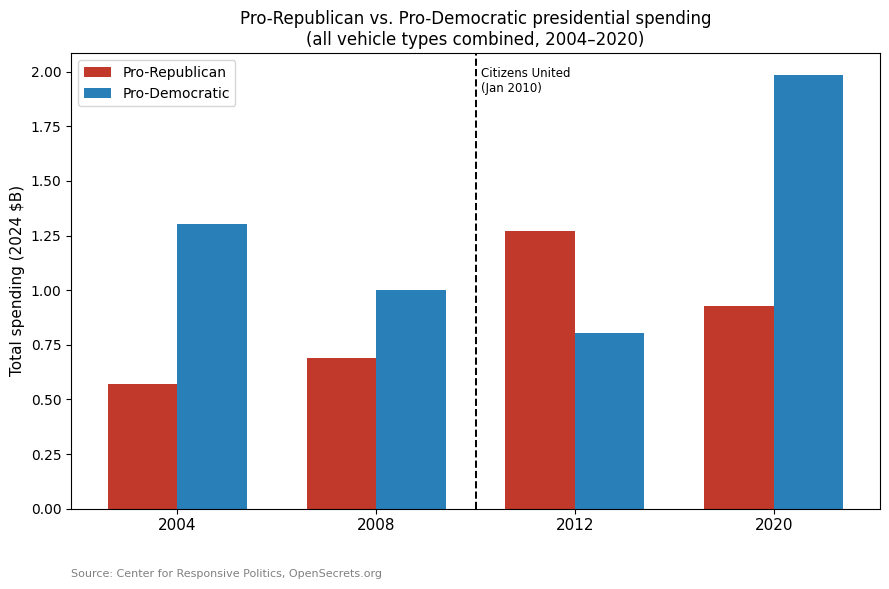

In [31]:
pro_r = df[df.partisan_direction == 'pro_R'].groupby('Cycle')['total'].sum() / 1e9 # get total pro-R spending by cycle and convert to billions
pro_d = df[df.partisan_direction == 'pro_D'].groupby('Cycle')['total'].sum() / 1e9 # get total pro-D spending by cycle and convert to billions

cycles = pro_r.index.tolist() # get list of cycles (x-axis labels)
x = list(range(len(cycles))) # make numeric x values for plotting
w = 0.35 #set bar width

fig, ax = plt.subplots(figsize=(9, 6)) # start new plot

ax.bar([i - w/2 for i in x], pro_r.values, w, label='Pro-Republican', color='#C0392B') # plot pro-R bars, shifted left by half bar width
ax.bar([i + w/2 for i in x], pro_d.values, w, label='Pro-Democratic',  color='#2980B9') # plot pro-D bars, shifted right by half bar width

# Citizens United line — between 2008 (x=1) and 2012 (x=2)
ax.axvline(x=1.5, color='black', linestyle='--', linewidth=1.4)
ax.text(1.53, 0.97, 'Citizens United\n(Jan 2010)',
        transform=ax.get_xaxis_transform(), fontsize=8.5, va='top')

# polish axes and labels
ax.set_xticks(x)
ax.set_xticklabels(cycles, fontsize=11)
ax.set_ylabel('Total spending (2024 $B)', fontsize=11)
ax.set_title('Pro-Republican vs. Pro-Democratic presidential spending\n(all vehicle types combined, 2004–2020)', fontsize=12)
ax.legend(fontsize=10)

ax.text(0, -0.15, 'Source: Center for Responsive Politics, OpenSecrets.org',
        transform=ax.transAxes, fontsize=8, color='gray')

# save figure
plt.tight_layout()
plt.savefig('../figures/q2_fig1_partisan_totals.pdf', bbox_inches='tight')
plt.show()


## 6. Figure 2 — Partisan gap over time by spending vehicle

Line chart: one line per vehicle (`pac_direct`, `pac_independent`, `individual`, `527`).
X = 4 cycles; Y = partisan gap (%). Horizontal dashed line at 0 = parity.
Vertical dashed line between 2008/2012 for CU.

Key visual: if the `pac_independent` line diverges from `pac_direct` post-CU, that's the CU partisan tilt signal.

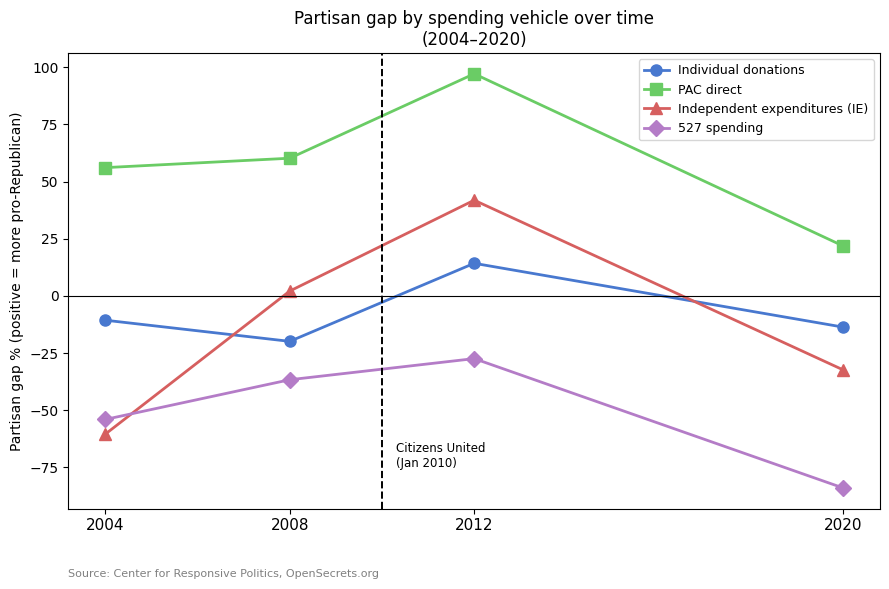

In [38]:
fig, ax = plt.subplots(figsize=(9, 6)) # start new plot

cycles_int = [int(c) for c in pivot.index] # get numberic cycle values for x axis

# style the lines for each type of spending
styles = {
    'individual':      ('#4878CF', 'o', 'Individual donations'),
    'pac_direct':      ('#6ACC65', 's', 'PAC direct'),
    'pac_independent': ('#D65F5F', '^', 'Independent expenditures (IE)'),
    '527':             ('#B47CC7', 'D', '527 spending'),
}

# for each column and it's stycles, plot the gap over time as a percentage (positive = more pro-R, negative = more pro-D)
for col, (color, marker, label) in styles.items():
    gaps = pivot[(col, 'pct_gap (>1 = more Rep)')]
    ax.plot(cycles_int, gaps.values, marker=marker, linewidth=2,
            markersize=8, color=color, label=label)

# add citizens united like
ax.axhline(0, color='black', linewidth=0.8, linestyle='-')
ax.axvline(x=2010, color='black', linestyle='--', linewidth=1.4)
ax.text(2010.3, ax.get_ylim()[1] * -0.6 if ax.get_ylim()[1] != 0 else 5,
        'Citizens United\n(Jan 2010)', fontsize=8.5, va='top')

# polishg the axes and labels
ax.set_xticks(cycles_int)
ax.set_xticklabels([str(c) for c in cycles_int], fontsize=11)
ax.set_ylabel('Partisan gap % (positive = more pro-Republican)', fontsize=10)
ax.set_title('Partisan gap by spending vehicle over time\n(2004–2020)', fontsize=12)
ax.legend(fontsize=9, loc='upper right')
ax.text(0, -0.15, 'Source: Center for Responsive Politics, OpenSecrets.org',
        transform=ax.transAxes, fontsize=8, color='gray')

# show and save plot
plt.tight_layout()
plt.savefig('../figures/q2_fig2_partisan_gap_by_vehicle.pdf', bbox_inches='tight')
plt.show()


## 7. Figure 3 — DID visualization

Two-panel bar chart showing pre vs. post-CU partisan gap for the control group (direct) and treatment group (IE).
Annotate the DID estimate on the figure.
This is the key empirical figure for Q2.

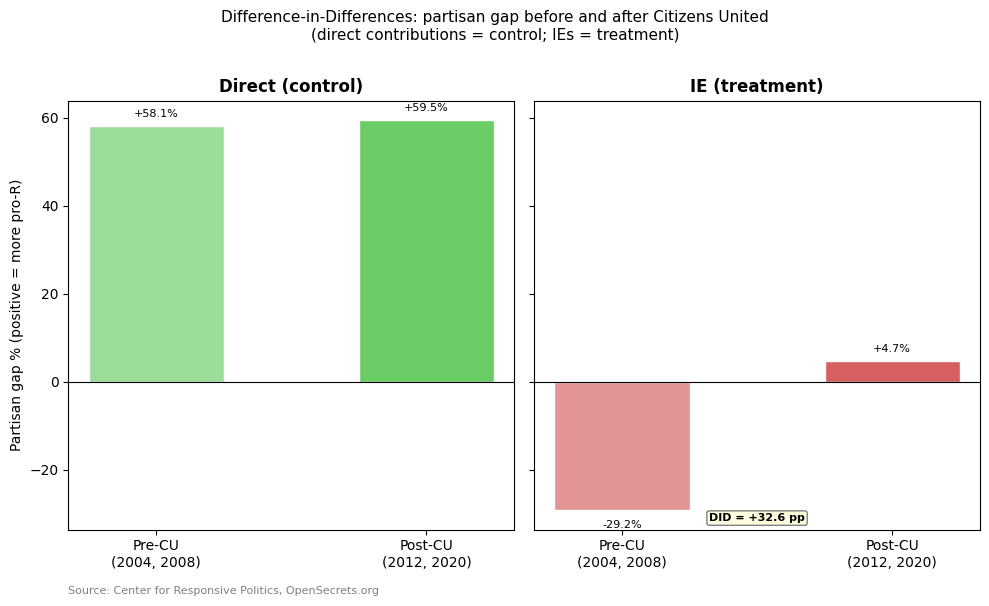

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True) # start new plot

groups  = ['Direct (control)', 'IE (treatment)'] # classify the groups for labeling
pre_vals  = [pre_direct,  pre_ie] #set pre-CU gap values for direct contributions and independent expenditures
post_vals = [post_direct, post_ie] #set post-CU gap values for direct contributions and independent expenditures
colors    = ['#6ACC65',   '#D65F5F'] # set colors

# for each group (direct contributions and independent expenditures), plot pre-CU and post-CU gaps as bars, with annotations
for ax, group, pre, post, color in zip(axes, groups, pre_vals, post_vals, colors):
    ax.bar(['Pre-CU\n(2004, 2008)', 'Post-CU\n(2012, 2020)'],
           [pre, post], color=[color + 'AA', color], edgecolor='white', width=0.5)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(group, fontsize=12, fontweight='bold')
    ax.set_ylabel('Partisan gap % (positive = more pro-R)' if ax == axes[0] else '', fontsize=10)
    # Annotate bar values
    for xpos, val in enumerate([pre, post]):
        ax.text(xpos, val + (2 if val >= 0 else -4), f'{val:+.1f}%',
                ha='center', fontsize=8)

# Annotate DID on second panel
axes[1].text(0.5, 0.02, f'DID = {did:+.1f} pp',
             transform=axes[1].transAxes, ha='center', fontsize=8,
             fontweight='bold', color='black',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', edgecolor='gray'))

fig.suptitle('Difference-in-Differences: partisan gap before and after Citizens United\n(direct contributions = control; IEs = treatment)',
             fontsize=11, y=1.01)

axes[0].text(0, -0.15, 'Source: Center for Responsive Politics, OpenSecrets.org',
             transform=axes[0].transAxes, fontsize=8, color='gray')

# show and save plot
plt.tight_layout()
plt.savefig('../figures/q2_fig3_did.pdf', bbox_inches='tight')
plt.show()


## 8. Save results tables

- `../tables/q2_partisan_gaps.csv` — partisan gap by cycle + spending type
- `../tables/q2_did_results.csv` — pre/post gaps and DID estimate
- `../tables/q2_spending_by_direction.csv` — raw pro_R / pro_D totals

In [50]:
gap_summary.to_csv('../tables/q2_partisan_gaps.csv')
print("Saved ../tables/q2_partisan_gaps.csv")

did_df.to_csv('../tables/q2_did_results.csv', index=False)
print("Saved ../tables/q2_did_results.csv")

# Raw pro_R / pro_D totals by cycle and vehicle
raw_totals = df.pivot_table(index=['Cycle', 'era'], columns=['spending_type', 'partisan_direction'],
                            values='total', aggfunc='sum').reset_index()
raw_totals.to_csv('../tables/q2_spending_by_direction.csv', index=False)
print("Saved ../tables/q2_spending_by_direction.csv")


Saved ../tables/q2_partisan_gaps.csv
Saved ../tables/q2_did_results.csv
Saved ../tables/q2_spending_by_direction.csv
